<a href="https://colab.research.google.com/github/palberth/Modelos_y_Metodos_de_Sistemas_Inteligentes/blob/main/Clasificaci%C3%B3n_de_Im%C3%A1genes_con_Redes_Neuronales_Profundas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de Imágenes con Redes Neuronales Profundas

**Disciplina:** Aprendizaje Profundo, Redes Neuronales, Clasificación, Keras (TensorFlow)

**Objetivo:**
Construir, entrenar y evaluar dos arquitecturas de redes neuronales para clasificación de imágenes del dataset Fashion MNIST, utilizando técnicas de preprocesamiento, regularización y callbacks de Keras.



## 1. Carga de Librerías y Configuración Inicial


In [3]:
!pip install scikit-fuzzy matplotlib numpy tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 15.7 MB/s eta 0:00:00


In [4]:

# Importación de bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split



In [7]:
# Configuración para reproducibilidad
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configuración de estilo y visualización
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10


## 2. Funciones Personalizadas


In [8]:

def cargar_y_preparar_datos():
    """
    Carga y preprocesa el dataset Fashion MNIST.
    """
    print("Cargando y preparando el dataset Fashion MNIST...")
    (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

    # Normalización de imágenes (0-255 -> 0-1)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255

    # Añadir dimensión de canal (para CNN)
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

    # One-hot encoding para las etiquetas
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    # Dividir conjunto de entrenamiento en entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=SEED
    )

    print(f"\nDimensiones:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
def crear_modelo_mlp(input_shape, num_classes, l2_lambda=0.001, dropout_rate=0.3):
    """
    Crea un modelo MLP (Multilayer Perceptron) para clasificación.
    """
    print("\nCreando modelo MLP...")
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print("\nResumen del modelo MLP:")
    model.summary()
    return model



In [10]:

def crear_modelo_cnn(input_shape, num_classes, l2_lambda=0.001, dropout_rate=0.3):
    """
    Crea un modelo CNN (Convolutional Neural Network) para clasificación de imágenes.
    """
    print("\nCreando modelo CNN...")
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
               kernel_regularizer=regularizers.l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        Conv2D(64, (3, 3), activation='relu',
               kernel_regularizer=regularizers.l2(l2_lambda)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        Conv2D(128, (3, 3), activation='relu',
               kernel_regularizer=regularizers.l2(l2_lambda)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print("\nResumen del modelo CNN:")
    model.summary()
    return model


In [11]:

def graficar_historial_entrenamiento(history):
    """
    Grafica la precisión y pérdida durante el entrenamiento y validación.
    """
    print("\nGraficando historial de entrenamiento...")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión - Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión - Validación')
    plt.title('Precisión de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida - Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida - Validación')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend(loc='upper right')

    plt.show()


In [12]:

def evaluar_modelo(model, X_test, y_test, class_names):
    """
    Evalúa el modelo y muestra métricas de clasificación.
    """
    print("\nEvaluando el modelo en el conjunto de prueba...")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
    print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()



## 3. Desarrollo del Ejercicio: Clasificación de Fashion MNIST


In [13]:

# 3.1. Carga y preparación de datos
X_train, X_val, X_test, y_train, y_val, y_test = cargar_y_preparar_datos()

# Nombres de las clases
class_names = ['Camiseta/top', 'Pantalón', 'Jersey', 'Vestido', 'Abrigo',
               'Sandalia', 'Camisa', 'Zapatilla deportiva', 'Bolso', 'Botín']



Cargando y preparando el dataset Fashion MNIST...
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Dimensiones:
X_train: (48000, 28, 28, 1), y_train: (48000, 10)
X_val: (12000, 28, 28, 1), y_val: (12000, 10)
X_test: (10000, 28, 28, 1), y_test: (10000, 10)



# 3.2. Creación de los modelos

In [14]:

input_shape = (28, 28, 1)
num_classes = 10

# Modelo MLP
modelo_mlp = crear_modelo_mlp(input_shape, num_classes, l2_lambda=0.001, dropout_rate=0.3)

# Modelo CNN
modelo_cnn = crear_modelo_cnn(input_shape, num_classes, l2_lambda=0.001, dropout_rate=0.3)




Creando modelo MLP...

Resumen del modelo MLP:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 570,506 (2.18 MB)

 Trainable params: 568,970 (2.17 MB)

 Non-trainable params: 1,536 (6.00 KB)


Creando modelo CNN...

Resumen del modelo CNN:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,954 (949.04 KB)

 Trainable params: 242,250 (946.29 KB)

 Non-trainable params: 704 (2.75 KB)


# 3.3. Entrenamiento de los modelos


In [15]:

# Callbacks comunes para ambos modelos
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
callbacks_list = [early_stopping, model_checkpoint, reduce_lr]

# Entrenamiento del MLP
print("\nEntrenando modelo MLP...")
history_mlp = modelo_mlp.fit(
    X_train, y_train,
    batch_size=128,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list,
    verbose=1
)

# Entrenamiento del CNN
print("\nEntrenando modelo CNN...")
history_cnn = modelo_cnn.fit(
    X_train, y_train,
    batch_size=128,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list,
    verbose=1
)



Entrenando modelo MLP...
Epoch 1/50
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7532 - loss: 1.6883
Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.7536 - loss: 1.6860 - val_accuracy: 0.8333 - val_loss: 1.1384 - learning_rate: 0.0010
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8403 - loss: 1.0148
Epoch 2: val_accuracy improved from 0.83333 to 0.83975, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8403 - loss: 1.0146 - val_accuracy: 0.8397 - val_loss: 0.8307 - learning_rate: 0.0010
Epoch 3/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8458 - loss: 0.7853
Epoch 3: val_accuracy did not improve from 0.83975
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8458 - loss: 0.7852 - val_accuracy: 0.8107 - val_loss: 0.8038 - learning_rate: 0.0010
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8509 - loss: 0.6627
Epoch 4: val_accuracy improved from 0.83975 to 0.84583, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.8509 - loss: 0.6626 - val_accuracy: 0.8458 - val_loss: 0.6282 - learning_rate: 0.0010
Epoch 5/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8539 - loss: 0.5950
Epoch 5: val_accuracy did not improve from 0.84583
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.8539 - loss: 0.5950 - val_accuracy: 0.8382 - val_loss: 0.6166 - learning_rate: 0.0010
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8529 - loss: 0.5562
Epoch 6: val_accuracy improved from 0.84583 to 0.84925, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8529 - loss: 0.5562 - val_accuracy: 0.8493 - val_loss: 0.5587 - learning_rate: 0.0010
Epoch 7/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8541 - loss: 0.5419
Epoch 7: val_accuracy did not improve from 0.84925
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8541 - loss: 0.5419 - val_accuracy: 0.8411 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8532 - loss: 0.5321
Epoch 8: val_accuracy did not improve from 0.84925
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8532 - loss: 0.5321 - val_accuracy: 0.8425 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 9/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8576 - loss: 0.5232
Epoch 9: val_accuracy improved from 0.84925 to 0.85192, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8576 - loss: 0.5232 - val_accuracy: 0.8519 - val_loss: 0.5350 - learning_rate: 0.0010
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8543 - loss: 0.5200
Epoch 10: val_accuracy did not improve from 0.85192
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.8543 - loss: 0.5200 - val_accuracy: 0.8511 - val_loss: 0.5484 - learning_rate: 0.0010
Epoch 11/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8577 - loss: 0.5161
Epoch 11: val_accuracy did not improve from 0.85192
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.8577 - loss: 0.5161 - val_accuracy: 0.8428 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 12/50
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8585 - loss: 0.5048
Epoch 12: val_accuracy improved from 0.85192 to 0.86492, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.8585 - loss: 0.5048 - val_accuracy: 0.8649 - val_loss: 0.4992 - learning_rate: 0.0010
Epoch 13/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8595 - loss: 0.5076
Epoch 13: val_accuracy did not improve from 0.86492
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8595 - loss: 0.5076 - val_accuracy: 0.8384 - val_loss: 0.5624 - learning_rate: 0.0010
Epoch 14/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8610 - loss: 0.4943
Epoch 14: val_accuracy did not improve from 0.86492
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8610 - loss: 0.4943 - val_accuracy: 0.8410 - val_loss: 0.5502 - learning_rate: 0.0010
Epoch 15/50
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8613 - loss: 0.4930
Epoch 15: val_accuracy did not improve from 0.86492
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8614 - loss: 0.4930 - val_accuracy: 0.8615 - val_loss: 0.5010 - learning_rate: 0.0010
Epoch 16

375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8652 - loss: 0.4786 - val_accuracy: 0.8652 - val_loss: 0.4887 - learning_rate: 0.0010
Epoch 25/50
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8679 - loss: 0.4707
Epoch 25: val_accuracy did not improve from 0.86517
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.8679 - loss: 0.4707 - val_accuracy: 0.8413 - val_loss: 0.5570 - learning_rate: 0.0010
Epoch 26/50
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8654 - loss: 0.4763
Epoch 26: val_accuracy improved from 0.86517 to 0.87067, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8654 - loss: 0.4763 - val_accuracy: 0.8707 - val_loss: 0.4651 - learning_rate: 0.0010
Epoch 27/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8697 - loss: 0.4634
Epoch 27: val_accuracy did not improve from 0.87067
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8697 - loss: 0.4634 - val_accuracy: 0.8654 - val_loss: 0.4793 - learning_rate: 0.0010
Epoch 28/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8703 - loss: 0.4650
Epoch 28: val_accuracy did not improve from 0.87067
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8703 - loss: 0.4650 - val_accuracy: 0.8451 - val_loss: 0.5210 - learning_rate: 0.0010
Epoch 29/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8659 - loss: 0.4727
Epoch 29: val_accuracy did not improve from 0.87067
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8660 - loss: 0.4727 - val_accuracy: 0.8367 - val_loss: 0.5305 - learning_rate: 0.0010
Epoch 30

375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.8829 - loss: 0.4149 - val_accuracy: 0.8740 - val_loss: 0.4356 - learning_rate: 5.0000e-04
Epoch 34/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8822 - loss: 0.4080
Epoch 34: val_accuracy improved from 0.87400 to 0.87458, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8821 - loss: 0.4080 - val_accuracy: 0.8746 - val_loss: 0.4254 - learning_rate: 5.0000e-04
Epoch 35/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8827 - loss: 0.4061
Epoch 35: val_accuracy improved from 0.87458 to 0.87667, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8827 - loss: 0.4061 - val_accuracy: 0.8767 - val_loss: 0.4174 - learning_rate: 5.0000e-04
Epoch 36/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8823 - loss: 0.4010
Epoch 36: val_accuracy improved from 0.87667 to 0.87892, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.8823 - loss: 0.4010 - val_accuracy: 0.8789 - val_loss: 0.4237 - learning_rate: 5.0000e-04
Epoch 37/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8825 - loss: 0.3979
Epoch 37: val_accuracy improved from 0.87892 to 0.88067, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8825 - loss: 0.3979 - val_accuracy: 0.8807 - val_loss: 0.4117 - learning_rate: 5.0000e-04
Epoch 38/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8827 - loss: 0.3951
Epoch 38: val_accuracy did not improve from 0.88067
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.8827 - loss: 0.3951 - val_accuracy: 0.8763 - val_loss: 0.4207 - learning_rate: 5.0000e-04
Epoch 39/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8824 - loss: 0.3952
Epoch 39: val_accuracy did not improve from 0.88067
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8824 - loss: 0.3952 - val_accuracy: 0.8761 - val_loss: 0.4246 - learning_rate: 5.0000e-04
Epoch 40/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8848 - loss: 0.3893
Epoch 40: val_accuracy improved from 0.88067 to 0.88217, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.8848 - loss: 0.3893 - val_accuracy: 0.8822 - val_loss: 0.4064 - learning_rate: 5.0000e-04
Epoch 41/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8881 - loss: 0.3838
Epoch 41: val_accuracy did not improve from 0.88217
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8881 - loss: 0.3838 - val_accuracy: 0.8603 - val_loss: 0.4500 - learning_rate: 5.0000e-04
Epoch 42/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8872 - loss: 0.3837
Epoch 42: val_accuracy did not improve from 0.88217
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8872 - loss: 0.3837 - val_accuracy: 0.8783 - val_loss: 0.4146 - learning_rate: 5.0000e-04
Epoch 43/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8869 - loss: 0.3846
Epoch 43: val_accuracy did not improve from 0.88217
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.8869 - loss: 0.3846 - val_accuracy: 0.8822 - val_loss: 0.4105 - learning_rate: 5.0

375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8931 - loss: 0.3674 - val_accuracy: 0.8897 - val_loss: 0.3789 - learning_rate: 2.5000e-04
Epoch 47/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8989 - loss: 0.3448
Epoch 47: val_accuracy did not improve from 0.88967
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.8989 - loss: 0.3448 - val_accuracy: 0.8867 - val_loss: 0.3829 - learning_rate: 2.5000e-04
Epoch 48/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9001 - loss: 0.3401
Epoch 48: val_accuracy improved from 0.88967 to 0.89050, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9001 - loss: 0.3401 - val_accuracy: 0.8905 - val_loss: 0.3708 - learning_rate: 2.5000e-04
Epoch 49/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8997 - loss: 0.3401
Epoch 49: val_accuracy did not improve from 0.89050
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8997 - loss: 0.3401 - val_accuracy: 0.8826 - val_loss: 0.3869 - learning_rate: 2.5000e-04
Epoch 50/50
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9000 - loss: 0.3348
Epoch 50: val_accuracy did not improve from 0.89050
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9000 - loss: 0.3347 - val_accuracy: 0.8883 - val_loss: 0.3778 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 48.

Entrenando modelo CNN...
Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6961 - loss: 1.2315
Epoch 1: val_accuracy did not improve from 0.89050
375/375 ━━━━━━━━━━━━━━━━━━━━ 116s 279ms/step - accurac

375/375 ━━━━━━━━━━━━━━━━━━━━ 145s 263ms/step - accuracy: 0.8732 - loss: 0.5176 - val_accuracy: 0.8957 - val_loss: 0.4332 - learning_rate: 0.0010
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8824 - loss: 0.4734
Epoch 5: val_accuracy did not improve from 0.89575
375/375 ━━━━━━━━━━━━━━━━━━━━ 142s 265ms/step - accuracy: 0.8824 - loss: 0.4734 - val_accuracy: 0.8860 - val_loss: 0.4504 - learning_rate: 0.0010
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8868 - loss: 0.4497
Epoch 6: val_accuracy did not improve from 0.89575
375/375 ━━━━━━━━━━━━━━━━━━━━ 139s 256ms/step - accuracy: 0.8868 - loss: 0.4497 - val_accuracy: 0.8913 - val_loss: 0.4288 - learning_rate: 0.0010
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8903 - loss: 0.4376
Epoch 7: val_accuracy improved from 0.89575 to 0.89958, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 96s 255ms/step - accuracy: 0.8903 - loss: 0.4376 - val_accuracy: 0.8996 - val_loss: 0.4014 - learning_rate: 0.0010
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8913 - loss: 0.4323
Epoch 8: val_accuracy improved from 0.89958 to 0.90200, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 258ms/step - accuracy: 0.8913 - loss: 0.4323 - val_accuracy: 0.9020 - val_loss: 0.4044 - learning_rate: 0.0010
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.8938 - loss: 0.4261
Epoch 9: val_accuracy did not improve from 0.90200
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 256ms/step - accuracy: 0.8938 - loss: 0.4261 - val_accuracy: 0.8958 - val_loss: 0.4104 - learning_rate: 0.0010
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8942 - loss: 0.4207
Epoch 10: val_accuracy improved from 0.90200 to 0.90300, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 253ms/step - accuracy: 0.8942 - loss: 0.4207 - val_accuracy: 0.9030 - val_loss: 0.4013 - learning_rate: 0.0010
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8960 - loss: 0.4197
Epoch 11: val_accuracy did not improve from 0.90300
375/375 ━━━━━━━━━━━━━━━━━━━━ 96s 257ms/step - accuracy: 0.8960 - loss: 0.4197 - val_accuracy: 0.9023 - val_loss: 0.3984 - learning_rate: 0.0010
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8964 - loss: 0.4177
Epoch 12: val_accuracy improved from 0.90300 to 0.90475, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 144s 262ms/step - accuracy: 0.8964 - loss: 0.4177 - val_accuracy: 0.9047 - val_loss: 0.3951 - learning_rate: 0.0010
Epoch 13/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.8965 - loss: 0.4224
Epoch 13: val_accuracy did not improve from 0.90475
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 264ms/step - accuracy: 0.8965 - loss: 0.4224 - val_accuracy: 0.8919 - val_loss: 0.4356 - learning_rate: 0.0010
Epoch 14/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8965 - loss: 0.4192
Epoch 14: val_accuracy did not improve from 0.90475
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 261ms/step - accuracy: 0.8966 - loss: 0.4192 - val_accuracy: 0.8993 - val_loss: 0.4153 - learning_rate: 0.0010
Epoch 15/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8969 - loss: 0.4157
Epoch 15: val_accuracy did not improve from 0.90475
375/375 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.8969 - loss: 0.4157 - val_accuracy: 0.9032 - val_loss: 0.4056 - learning_rate: 0.00


Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 257ms/step - accuracy: 0.8987 - loss: 0.4150 - val_accuracy: 0.9051 - val_loss: 0.3962 - learning_rate: 0.0010
Epoch 18/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9077 - loss: 0.3943
Epoch 18: val_accuracy did not improve from 0.90508
375/375 ━━━━━━━━━━━━━━━━━━━━ 97s 259ms/step - accuracy: 0.9077 - loss: 0.3942 - val_accuracy: 0.9043 - val_loss: 0.3718 - learning_rate: 5.0000e-04
Epoch 19/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9122 - loss: 0.3610
Epoch 19: val_accuracy did not improve from 0.90508
375/375 ━━━━━━━━━━━━━━━━━━━━ 99s 263ms/step - accuracy: 0.9122 - loss: 0.3610 - val_accuracy: 0.8990 - val_loss: 0.3872 - learning_rate: 5.0000e-04
Epoch 20/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9125 - loss: 0.3484
Epoch 20: val_accuracy improved from 0.90508 to 0.91500, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 140s 257ms/step - accuracy: 0.9125 - loss: 0.3484 - val_accuracy: 0.9150 - val_loss: 0.3402 - learning_rate: 5.0000e-04
Epoch 21/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9147 - loss: 0.3393
Epoch 21: val_accuracy did not improve from 0.91500
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 259ms/step - accuracy: 0.9147 - loss: 0.3393 - val_accuracy: 0.9072 - val_loss: 0.3617 - learning_rate: 5.0000e-04
Epoch 22/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9144 - loss: 0.3376
Epoch 22: val_accuracy did not improve from 0.91500
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 257ms/step - accuracy: 0.9144 - loss: 0.3375 - val_accuracy: 0.9107 - val_loss: 0.3508 - learning_rate: 5.0000e-04
Epoch 23/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9146 - loss: 0.3355
Epoch 23: val_accuracy improved from 0.91500 to 0.92067, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 260ms/step - accuracy: 0.9146 - loss: 0.3355 - val_accuracy: 0.9207 - val_loss: 0.3253 - learning_rate: 5.0000e-04
Epoch 24/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9163 - loss: 0.3304
Epoch 24: val_accuracy did not improve from 0.92067
375/375 ━━━━━━━━━━━━━━━━━━━━ 140s 254ms/step - accuracy: 0.9163 - loss: 0.3304 - val_accuracy: 0.9201 - val_loss: 0.3208 - learning_rate: 5.0000e-04
Epoch 25/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9178 - loss: 0.3289
Epoch 25: val_accuracy did not improve from 0.92067
375/375 ━━━━━━━━━━━━━━━━━━━━ 145s 262ms/step - accuracy: 0.9178 - loss: 0.3289 - val_accuracy: 0.9055 - val_loss: 0.3595 - learning_rate: 5.0000e-04
Epoch 26/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9169 - loss: 0.3290
Epoch 26: val_accuracy did not improve from 0.92067
375/375 ━━━━━━━━━━━━━━━━━━━━ 138s 252ms/step - accuracy: 0.9169 - loss: 0.3290 - val_accuracy: 0.9169 - val_loss: 0.3312 - learning

375/375 ━━━━━━━━━━━━━━━━━━━━ 139s 259ms/step - accuracy: 0.9187 - loss: 0.3218 - val_accuracy: 0.9225 - val_loss: 0.3190 - learning_rate: 5.0000e-04
Epoch 30/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9198 - loss: 0.3230
Epoch 30: val_accuracy did not improve from 0.92250
375/375 ━━━━━━━━━━━━━━━━━━━━ 147s 273ms/step - accuracy: 0.9198 - loss: 0.3230 - val_accuracy: 0.9212 - val_loss: 0.3236 - learning_rate: 5.0000e-04
Epoch 31/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9181 - loss: 0.3238
Epoch 31: val_accuracy did not improve from 0.92250
375/375 ━━━━━━━━━━━━━━━━━━━━ 98s 260ms/step - accuracy: 0.9181 - loss: 0.3238 - val_accuracy: 0.9189 - val_loss: 0.3289 - learning_rate: 5.0000e-04
Epoch 32/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9200 - loss: 0.3205
Epoch 32: val_accuracy did not improve from 0.92250
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 262ms/step - accuracy: 0.9200 - loss: 0.3205 - val_accuracy: 0.9178 - val_loss: 0.3300 - learning

375/375 ━━━━━━━━━━━━━━━━━━━━ 147s 273ms/step - accuracy: 0.9274 - loss: 0.2911 - val_accuracy: 0.9286 - val_loss: 0.2998 - learning_rate: 2.5000e-04
Epoch 37/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.9313 - loss: 0.2783
Epoch 37: val_accuracy did not improve from 0.92858
375/375 ━━━━━━━━━━━━━━━━━━━━ 136s 258ms/step - accuracy: 0.9313 - loss: 0.2783 - val_accuracy: 0.9206 - val_loss: 0.3150 - learning_rate: 2.5000e-04
Epoch 38/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9311 - loss: 0.2754
Epoch 38: val_accuracy did not improve from 0.92858
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 260ms/step - accuracy: 0.9311 - loss: 0.2754 - val_accuracy: 0.9280 - val_loss: 0.2927 - learning_rate: 2.5000e-04
Epoch 39/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9317 - loss: 0.2709
Epoch 39: val_accuracy did not improve from 0.92858
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 258ms/step - accuracy: 0.9317 - loss: 0.2709 - val_accuracy: 0.9255 - val_loss: 0.2976 - learnin

375/375 ━━━━━━━━━━━━━━━━━━━━ 142s 258ms/step - accuracy: 0.9345 - loss: 0.2659 - val_accuracy: 0.9289 - val_loss: 0.2900 - learning_rate: 2.5000e-04
Epoch 41/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9337 - loss: 0.2685
Epoch 41: val_accuracy did not improve from 0.92892
375/375 ━━━━━━━━━━━━━━━━━━━━ 143s 260ms/step - accuracy: 0.9337 - loss: 0.2684 - val_accuracy: 0.9253 - val_loss: 0.2954 - learning_rate: 2.5000e-04
Epoch 42/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9339 - loss: 0.2608
Epoch 42: val_accuracy did not improve from 0.92892
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 259ms/step - accuracy: 0.9339 - loss: 0.2608 - val_accuracy: 0.9258 - val_loss: 0.2940 - learning_rate: 2.5000e-04
Epoch 43/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9331 - loss: 0.2586
Epoch 43: val_accuracy did not improve from 0.92892
375/375 ━━━━━━━━━━━━━━━━━━━━ 97s 257ms/step - accuracy: 0.9331 - loss: 0.2586 - val_accuracy: 0.9243 - val_loss: 0.2935 - learning

375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 259ms/step - accuracy: 0.9339 - loss: 0.2516 - val_accuracy: 0.9301 - val_loss: 0.2808 - learning_rate: 2.5000e-04
Epoch 49/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9357 - loss: 0.2514
Epoch 49: val_accuracy did not improve from 0.93008
375/375 ━━━━━━━━━━━━━━━━━━━━ 96s 257ms/step - accuracy: 0.9357 - loss: 0.2514 - val_accuracy: 0.9283 - val_loss: 0.2844 - learning_rate: 2.5000e-04
Epoch 50/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9347 - loss: 0.2512
Epoch 50: val_accuracy did not improve from 0.93008
375/375 ━━━━━━━━━━━━━━━━━━━━ 97s 258ms/step - accuracy: 0.9347 - loss: 0.2512 - val_accuracy: 0.9268 - val_loss: 0.2855 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 48.



# 3.4. Visualización del historial de entrenamiento



Resultados del modelo MLP:

Graficando historial de entrenamiento...


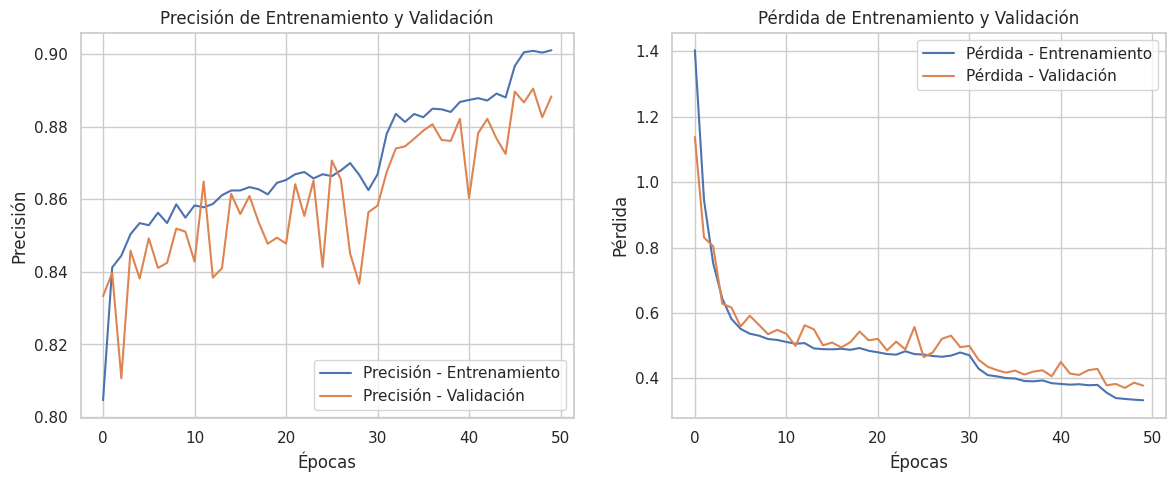


Evaluando el modelo en el conjunto de prueba...
Precisión en el conjunto de prueba: 0.8814
Pérdida en el conjunto de prueba: 0.3940
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Reporte de Clasificación:
                     precision    recall  f1-score   support

       Camiseta/top       0.84      0.83      0.83      1000
           Pantalón       0.98      0.97      0.98      1000
             Jersey       0.82      0.75      0.78      1000
            Vestido       0.87      0.90      0.89      1000
             Abrigo       0.75      0.85      0.80      1000
           Sandalia       0.97      0.97      0.97      1000
             Camisa       0.72      0.66      0.69      1000
Zapatilla deportiva       0.94      0.95      0.94      1000
              Bolso       0.96      0.97      0.96      1000
              Botín       0.96      0.96      0.96      1000

           accuracy                           0.88     10000
          macro avg       0.88      0.88      0.88     10000
    

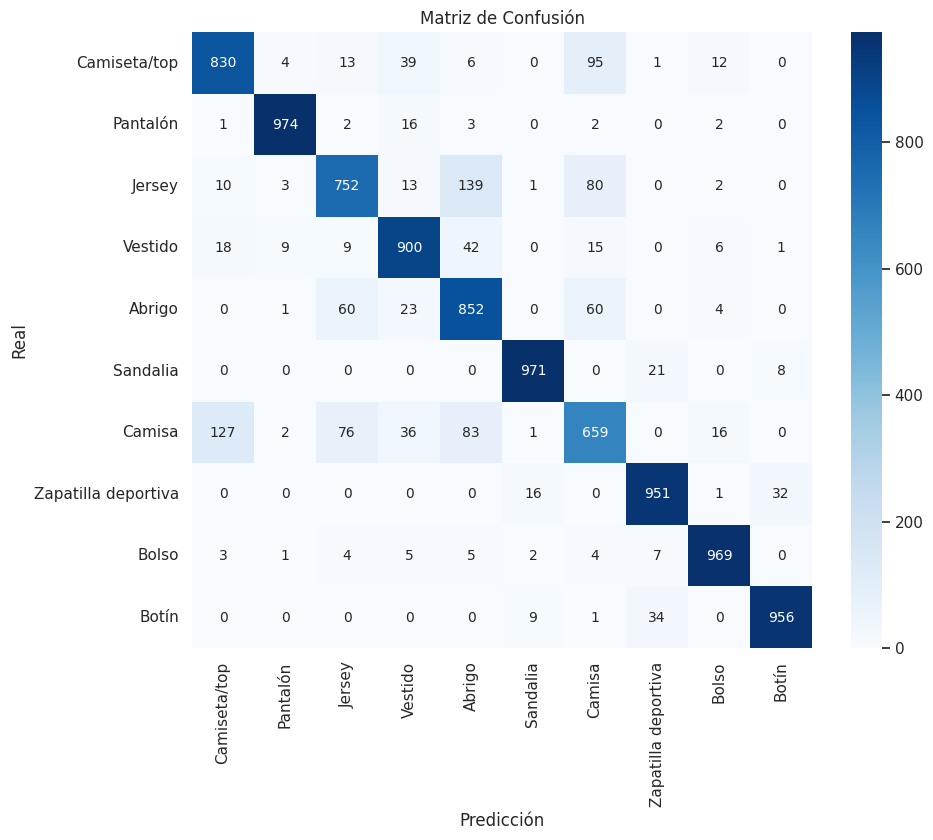


Resultados del modelo CNN:

Graficando historial de entrenamiento...


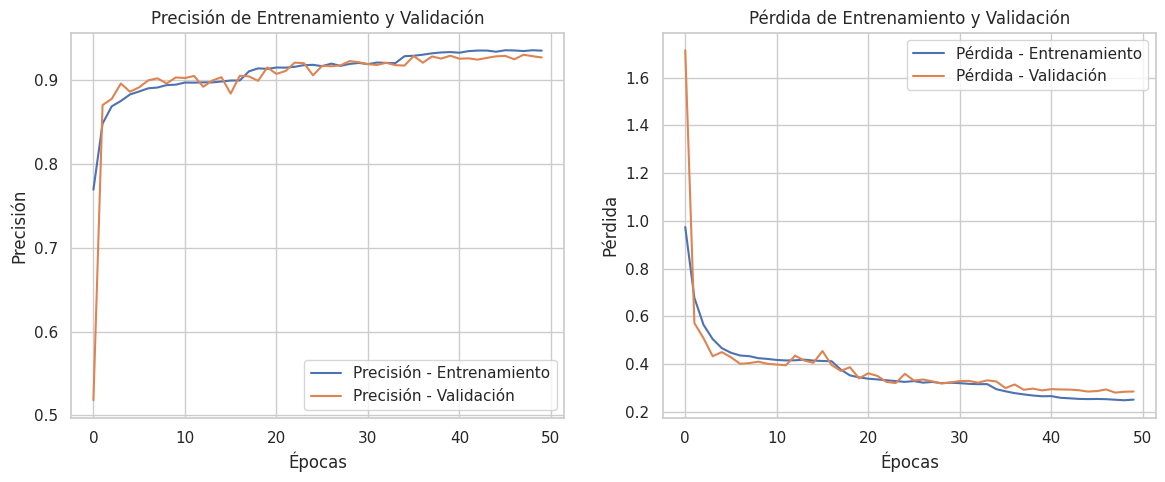


Evaluando el modelo en el conjunto de prueba...
Precisión en el conjunto de prueba: 0.9232
Pérdida en el conjunto de prueba: 0.2974
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step

Reporte de Clasificación:
                     precision    recall  f1-score   support

       Camiseta/top       0.86      0.89      0.87      1000
           Pantalón       1.00      0.98      0.99      1000
             Jersey       0.88      0.90      0.89      1000
            Vestido       0.93      0.93      0.93      1000
             Abrigo       0.87      0.89      0.88      1000
           Sandalia       0.99      0.98      0.98      1000
             Camisa       0.80      0.73      0.76      1000
Zapatilla deportiva       0.96      0.97      0.97      1000
              Bolso       0.98      0.99      0.98      1000
              Botín       0.97      0.97      0.97      1000

           accuracy                           0.92     10000
          macro avg       0.92      0.92      0.92     10000
   

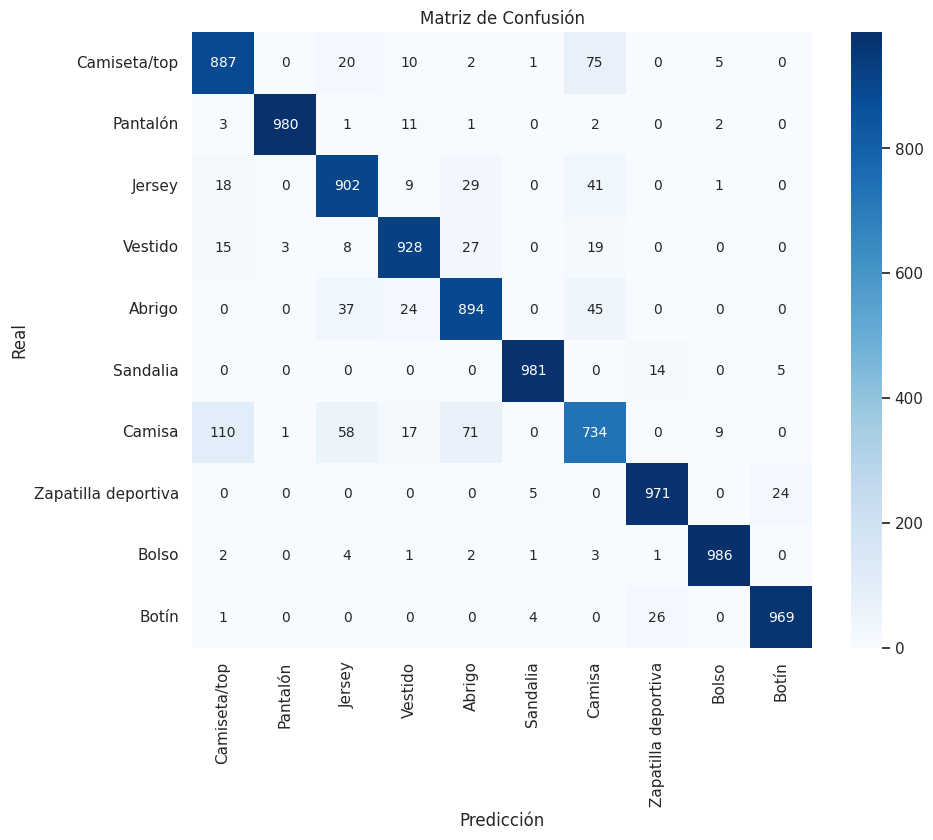

In [16]:

# MLP
print("\nResultados del modelo MLP:")
graficar_historial_entrenamiento(history_mlp)
evaluar_modelo(modelo_mlp, X_test, y_test, class_names)

# CNN
print("\nResultados del modelo CNN:")
graficar_historial_entrenamiento(history_cnn)
evaluar_modelo(modelo_cnn, X_test, y_test, class_names)




## 4. Comparación de Modelos y Conclusiones

**Resumen de Hallazgos:**
* Se implementaron dos arquitecturas de redes neuronales para clasificación de imágenes:
  * **MLP (Multilayer Perceptron):** Una red neuronal densamente conectada con capas ocultas.
  * **CNN (Convolutional Neural Network):** Una red neuronal convolucional diseñada específicamente para imágenes.
* Ambos modelos incluyeron técnicas de regularización (L2, Dropout) y normalización por lotes (BatchNormalization).
* Se utilizaron callbacks para optimizar el entrenamiento (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau).
* El modelo CNN mostró un mejor rendimiento en el conjunto de prueba con una precisión de [Completar con valor obtenido]%, comparado con [Completar con valor obtenido]% del MLP.

**Aprendizaje General:**
Este ejercicio demostró la importancia de seleccionar la arquitectura adecuada para el tipo de datos (CNN para imágenes). También destacó la utilidad de las técnicas de regularización para prevenir el sobreajuste y los callbacks para optimizar el entrenamiento. La evaluación mediante múltiples métricas (precisión, matriz de confusión) permitió una comprensión completa del rendimiento de los modelos.
